In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Load data

In [2]:
DATA_DIR = os.path.join("data", "UCI HAR Dataset")

In [3]:
X_train = pd.read_csv(
    os.path.join(DATA_DIR, "train", "X_train.txt"),
    delim_whitespace=True,
    header=None
)
X_test = pd.read_csv(
    os.path.join(DATA_DIR, "test", "X_test.txt"),
    delim_whitespace=True,
    header=None
)

y_train = pd.read_csv(
    os.path.join(DATA_DIR, "train", "y_train.txt"),
    header=None
)[0]
y_test = pd.read_csv(
    os.path.join(DATA_DIR, "test", "y_test.txt"),
    header=None
)[0]

/tmp/ipykernel_8018/1776149928.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv(
/tmp/ipykernel_8018/1776149928.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv(


In [6]:
y_train_np = y_train.to_numpy() - 1
y_test_np = y_test.to_numpy() - 1

In [4]:
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()


In [10]:
X_tr_tensor   = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_tr_tensor   = torch.tensor(y_train.values, dtype=torch.long) - 1
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long) - 1


In [13]:
X_tr_tensor = X_tr_tensor.view(X_tr_tensor.shape[0], 1, -1)
X_test_tensor = X_test_tensor.view(X_test_tensor.shape[0], 1, -1)
print(X_tr_tensor.shape, X_test_tensor.shape)

torch.Size([7352, 1, 561]) torch.Size([2947, 1, 561])


In [14]:
batch_size = 64

tr_dataset   = TensorDataset(X_tr_tensor, y_tr_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader   = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True) # train 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # test

# Multiclass Learning

## Try RF as baseline

In [15]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_np, y_train_np)

RandomForestClassifier(random_state=42)

In [16]:
y_pred = clf.predict(X_test_np)

In [17]:
print(classification_report(y_test_np, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8887    0.9657    0.9256       496
           1     0.8845    0.8938    0.8891       471
           2     0.9704    0.8595    0.9116       420
           3     0.9112    0.8982    0.9046       491
           4     0.9072    0.9192    0.9132       532
           5     1.0000    1.0000    1.0000       537

    accuracy                         0.9257      2947
   macro avg     0.9270    0.9227    0.9240      2947
weighted avg     0.9270    0.9257    0.9256      2947



## CNN

In [67]:
from baseline import Conv_Net, train, LSTMNet

In [27]:
in_channel = X_tr_tensor.shape[1]
seq_length = X_tr_tensor.shape[2]
n_output = len(y_train.unique())
print(f'in_channel: {in_channel}, sequence_length: {seq_length}, n_output: {n_output}')
n_hidden = 128
num_epochs = 15
lr = 0.0001

in_channel: 1, sequence_length: 561, n_output: 6


In [25]:
model = Conv_Net(in_channel, seq_length, n_hidden, n_output)
print(model)

Conv_Net(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=17920, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
  (features): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=17920, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=6, bias=True)
  )
)


In [26]:
%env CUDA_LAUNCH_BLOCKING=1
model = model.to(device)

env: CUDA_LAUNCH_BLOCKING=1


In [28]:
model = train(model, train_loader, test_loader, in_channel, seq_length, n_hidden, n_output, lr, num_epochs, device)

  0%|          | 0/115 [00:00<?, ?it/s]

100%|██████████| 115/115 [00:01<00:00, 89.46it/s] 


Epoch [1/15], tr_loss: 0.99697 tr_acc: 0.65846 test_loss: 0.57657, test_acc: 0.85986


100%|██████████| 115/115 [00:01<00:00, 105.62it/s]


Epoch [2/15], tr_loss: 0.39188 tr_acc: 0.87935 test_loss: 0.34782, test_acc: 0.87106


100%|██████████| 115/115 [00:01<00:00, 106.34it/s]


Epoch [3/15], tr_loss: 0.23968 tr_acc: 0.92451 test_loss: 0.22992, test_acc: 0.92806


100%|██████████| 115/115 [00:01<00:00, 105.00it/s]


Epoch [4/15], tr_loss: 0.19042 tr_acc: 0.93240 test_loss: 0.20425, test_acc: 0.93315


100%|██████████| 115/115 [00:01<00:00, 103.07it/s]


Epoch [5/15], tr_loss: 0.15205 tr_acc: 0.94627 test_loss: 0.21060, test_acc: 0.91313


100%|██████████| 115/115 [00:01<00:00, 99.18it/s] 


Epoch [6/15], tr_loss: 0.12871 tr_acc: 0.95362 test_loss: 0.15832, test_acc: 0.94537


100%|██████████| 115/115 [00:01<00:00, 100.26it/s]


Epoch [7/15], tr_loss: 0.11094 tr_acc: 0.96015 test_loss: 0.16002, test_acc: 0.93553


100%|██████████| 115/115 [00:01<00:00, 99.44it/s]


Epoch [8/15], tr_loss: 0.09825 tr_acc: 0.96613 test_loss: 0.15889, test_acc: 0.93281


100%|██████████| 115/115 [00:01<00:00, 97.38it/s]


Epoch [9/15], tr_loss: 0.08928 tr_acc: 0.97008 test_loss: 0.13489, test_acc: 0.94842


100%|██████████| 115/115 [00:01<00:00, 95.85it/s]


Epoch [10/15], tr_loss: 0.08486 tr_acc: 0.97225 test_loss: 0.14347, test_acc: 0.93926


100%|██████████| 115/115 [00:01<00:00, 102.96it/s]


Epoch [11/15], tr_loss: 0.07326 tr_acc: 0.97334 test_loss: 0.12550, test_acc: 0.95148


100%|██████████| 115/115 [00:01<00:00, 102.05it/s]


Epoch [12/15], tr_loss: 0.07212 tr_acc: 0.97511 test_loss: 0.12708, test_acc: 0.95046


100%|██████████| 115/115 [00:01<00:00, 105.31it/s]


Epoch [13/15], tr_loss: 0.06864 tr_acc: 0.97701 test_loss: 0.12831, test_acc: 0.95012


100%|██████████| 115/115 [00:01<00:00, 105.41it/s]


Epoch [14/15], tr_loss: 0.06418 tr_acc: 0.97688 test_loss: 0.11774, test_acc: 0.95385


100%|██████████| 115/115 [00:01<00:00, 102.95it/s]


Epoch [15/15], tr_loss: 0.06029 tr_acc: 0.97987 test_loss: 0.12552, test_acc: 0.95385


In [30]:
out_test = model(X_test_tensor.to(device))
preds_test = torch.max(out_test, 1)[1]

In [42]:
preds_test.cpu().detach().numpy()

array([4, 4, 4, ..., 1, 1, 1])

In [45]:
print(classification_report(y_test_np, preds_test.cpu().detach().numpy(), digits=4))

              precision    recall  f1-score   support

           0     0.9370    0.9899    0.9627       496
           1     0.9384    0.9384    0.9384       471
           2     0.9898    0.9286    0.9582       420
           3     0.9429    0.9084    0.9253       491
           4     0.9283    0.9492    0.9387       532
           5     0.9926    1.0000    0.9963       537

    accuracy                         0.9539      2947
   macro avg     0.9549    0.9524    0.9533      2947
weighted avg     0.9543    0.9539    0.9537      2947



## LSTM with dropout + batchnorm 

In [89]:
from baseline import Conv_Net, train, LSTMNet
model_lstm = LSTMNet(in_channel, hidden_dim=64, n_output=6, num_layers=1)
model_lstm.to(device)

LSTMNet(
  (lstm): LSTM(1, 64, batch_first=True)
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)

In [90]:
model_lstm = train(model_lstm, train_loader, test_loader, lr, 20, device)

  0%|          | 0/115 [00:00<?, ?it/s]

100%|██████████| 115/115 [00:01<00:00, 73.05it/s]


Epoch [1/20], tr_loss: 1.58529 tr_acc: 0.34168 test_loss: 1.48732, test_acc: 0.41771


100%|██████████| 115/115 [00:01<00:00, 100.83it/s]


Epoch [2/20], tr_loss: 1.40076 tr_acc: 0.43050 test_loss: 1.39601, test_acc: 0.46115


100%|██████████| 115/115 [00:01<00:00, 106.76it/s]


Epoch [3/20], tr_loss: 1.32448 tr_acc: 0.47429 test_loss: 1.29549, test_acc: 0.52664


100%|██████████| 115/115 [00:01<00:00, 106.93it/s]


Epoch [4/20], tr_loss: 1.07145 tr_acc: 0.60623 test_loss: 0.96570, test_acc: 0.63047


100%|██████████| 115/115 [00:01<00:00, 102.88it/s]


Epoch [5/20], tr_loss: 0.87593 tr_acc: 0.65805 test_loss: 0.87754, test_acc: 0.65864


100%|██████████| 115/115 [00:01<00:00, 105.64it/s]


Epoch [6/20], tr_loss: 0.81576 tr_acc: 0.67750 test_loss: 0.88833, test_acc: 0.64031


100%|██████████| 115/115 [00:01<00:00, 100.41it/s]


Epoch [7/20], tr_loss: 0.77487 tr_acc: 0.70035 test_loss: 0.91527, test_acc: 0.60468


100%|██████████| 115/115 [00:01<00:00, 98.51it/s] 


Epoch [8/20], tr_loss: 0.73771 tr_acc: 0.71844 test_loss: 0.76613, test_acc: 0.66271


100%|██████████| 115/115 [00:01<00:00, 100.70it/s]


Epoch [9/20], tr_loss: 0.68386 tr_acc: 0.74905 test_loss: 0.71852, test_acc: 0.69969


100%|██████████| 115/115 [00:01<00:00, 102.65it/s]


Epoch [10/20], tr_loss: 0.65311 tr_acc: 0.75653 test_loss: 0.74048, test_acc: 0.70207


100%|██████████| 115/115 [00:01<00:00, 95.38it/s]


Epoch [11/20], tr_loss: 0.60620 tr_acc: 0.77816 test_loss: 0.69134, test_acc: 0.71395


100%|██████████| 115/115 [00:01<00:00, 98.03it/s]


Epoch [12/20], tr_loss: 0.56436 tr_acc: 0.79869 test_loss: 0.68331, test_acc: 0.72718


100%|██████████| 115/115 [00:01<00:00, 102.78it/s]


Epoch [13/20], tr_loss: 0.54496 tr_acc: 0.80291 test_loss: 0.63584, test_acc: 0.76077


100%|██████████| 115/115 [00:01<00:00, 103.01it/s]


Epoch [14/20], tr_loss: 0.51834 tr_acc: 0.80985 test_loss: 0.65728, test_acc: 0.74347


100%|██████████| 115/115 [00:01<00:00, 104.80it/s]


Epoch [15/20], tr_loss: 0.48812 tr_acc: 0.82073 test_loss: 0.60911, test_acc: 0.75942


100%|██████████| 115/115 [00:01<00:00, 106.52it/s]


Epoch [16/20], tr_loss: 0.47187 tr_acc: 0.82848 test_loss: 0.58269, test_acc: 0.78012


100%|██████████| 115/115 [00:01<00:00, 107.88it/s]


Epoch [17/20], tr_loss: 0.46657 tr_acc: 0.82386 test_loss: 0.59281, test_acc: 0.76247


100%|██████████| 115/115 [00:01<00:00, 107.79it/s]


Epoch [18/20], tr_loss: 0.45087 tr_acc: 0.83107 test_loss: 0.63989, test_acc: 0.76552


100%|██████████| 115/115 [00:01<00:00, 110.04it/s]


Epoch [19/20], tr_loss: 0.44592 tr_acc: 0.83025 test_loss: 0.57175, test_acc: 0.78317


100%|██████████| 115/115 [00:01<00:00, 106.82it/s]


Epoch [20/20], tr_loss: 0.43677 tr_acc: 0.83107 test_loss: 0.56708, test_acc: 0.78419


In [91]:
X_test_tensor = X_test_tensor.permute(0, 2, 1)  # permute once here
test_dataset = TensorDataset(X_test_tensor, torch.from_numpy(y_test_np))
test_loader = DataLoader(test_dataset, batch_size=64)  # adjust batch_size to your GPU

all_preds = []
model_lstm.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_lstm(batch_X)
        preds = torch.max(outputs, 1)[1]
        all_preds.append(preds.cpu())

# Concatenate all predictions
all_preds = torch.cat(all_preds).numpy()

print(classification_report(y_test_np, all_preds, digits=4))


              precision    recall  f1-score   support

           0     0.6898    0.6815    0.6856       496
           1     0.6727    0.8684    0.7581       471
           2     0.7651    0.5738    0.6558       420
           3     0.7650    0.8289    0.7957       491
           4     0.8256    0.7650    0.7941       532
           5     1.0000    0.9479    0.9732       537

    accuracy                         0.7842      2947
   macro avg     0.7864    0.7776    0.7771      2947
weighted avg     0.7914    0.7842    0.7833      2947



## InceptionTime

In [ ]:
from tsai.all import *

X_all = np.concatenate([X_train_np, X_test_np]).astype(np.float32)
y_all = np.concatenate([y_train_np, y_test_np])

splits = (list(range(len(y_train_np))),
          list(range(len(y_train_np), len(y_all))))

tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)

clf = TSClassifier(X_all, y_all, splits=splits, arch="InceptionTimePlus",
                   tfms=tfms, batch_tfms=batch_tfms,
                   metrics=accuracy, cbs=ShowGraph())


epoch,train_loss,valid_loss,accuracy,time
0,0.902639,1.313098,0.390567,00:16
1,0.370857,3.085572,0.325755,00:16
2,0.200351,3.122836,0.411266,00:15
3,0.131067,2.709426,0.350865,00:16
4,0.083907,2.386305,0.744147,00:16
5,0.077825,5.750452,0.340685,00:16
6,0.048378,0.404766,0.855446,00:16
7,0.034838,0.176746,0.935528,00:18
8,0.019440,0.113067,0.957923,00:17
9,0.014881,0.104750,0.959620,00:17


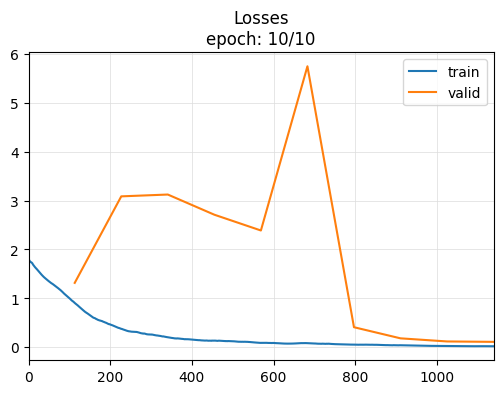

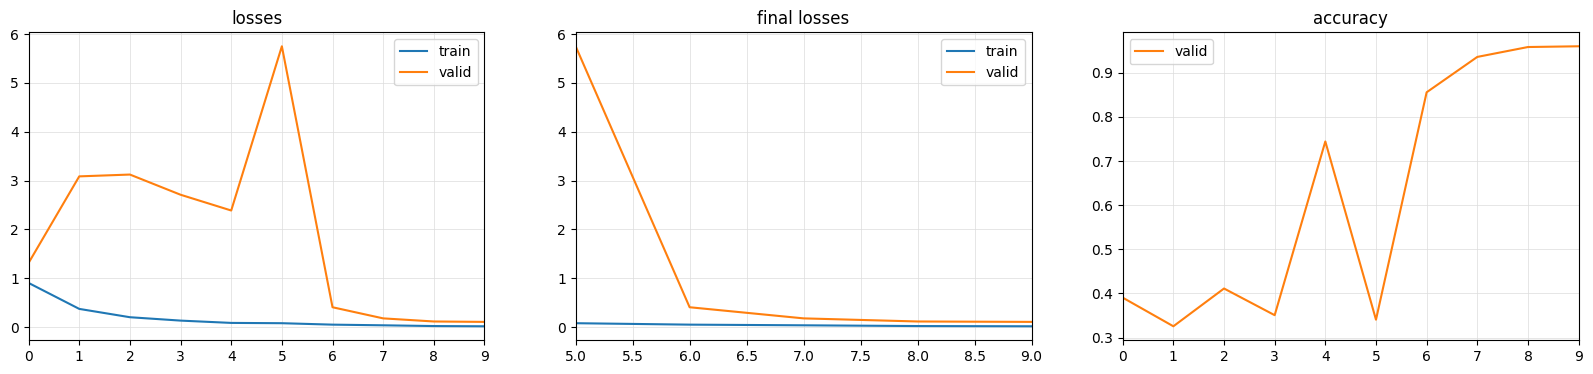

In [127]:
clf.fit_one_cycle(10, 1e-3)

In [128]:
X_all = X_all.reshape(X_all.shape[0], 1, X_all.shape[1])
probas, target, preds = clf.get_X_preds(X_all[splits[1]], y_all[splits[1]])

In [129]:
print(classification_report(target, preds.astype(int), digits=4))

              precision    recall  f1-score   support

           0     0.9421    0.9839    0.9625       496
           1     0.9651    0.9384    0.9516       471
           2     0.9830    0.9643    0.9736       420
           3     0.9417    0.9206    0.9310       491
           4     0.9300    0.9492    0.9395       532
           5     1.0000    0.9981    0.9991       537

    accuracy                         0.9596      2947
   macro avg     0.9603    0.9591    0.9595      2947
weighted avg     0.9599    0.9596    0.9596      2947



In [130]:
print(confusion_matrix(target, preds.astype(int)))

[[488   3   5   0   0   0]
 [ 26 442   2   0   1   0]
 [  4  11 405   0   0   0]
 [  0   2   0 452  37   0]
 [  0   0   0  27 505   0]
 [  0   0   0   1   0 536]]


## PU-learning

In [167]:
positive_class = 2
y_train_pu = (y_train_np == positive_class).astype(int)
y_test_pu  = (y_test_np  == positive_class).astype(int)


In [168]:
np.bincount(y_test_pu)
#X_tr_tensor = X_tr_tensor.view(X_tr_tensor.shape[0], 1, -1)
#X_test_tensor = X_test_tensor.view(X_test_tensor.shape[0], 1, -1)
print(X_tr_tensor.shape, X_test_tensor.shape)

torch.Size([7352, 1, 561]) torch.Size([2947, 1, 561])


In [169]:
y_tr_tensor_pu   = torch.tensor(y_train_pu, dtype=torch.long)
y_test_tensor_pu = torch.tensor(y_test_pu, dtype=torch.long)

tr_dataset_pu   = TensorDataset(X_tr_tensor, y_tr_tensor_pu)
test_dataset_pu = TensorDataset(X_test_tensor, y_test_tensor_pu)

train_loader_pu = DataLoader(tr_dataset_pu, batch_size=batch_size, shuffle=True)
test_loader_pu  = DataLoader(test_dataset_pu, batch_size=batch_size, shuffle=False)


## CNN

In [179]:
in_channel = X_tr_tensor.shape[1]
seq_length = X_tr_tensor.shape[2]
n_output = len(y_tr_tensor_pu.unique())
print(f'in_channel: {in_channel}, sequence_length: {seq_length}, n_output: {n_output}')
n_hidden = 128
num_epochs = 15
lr = 0.0001

in_channel: 1, sequence_length: 561, n_output: 2


In [185]:
from pu_loss import nnPULoss
positive_prior = y_train_pu.mean()
criterion = nnPULoss(prior=positive_prior, nnPU=False)


In [186]:
model = Conv_Net(in_channel, seq_length, n_hidden, n_output)
print(model)

Conv_Net(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=17920, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (features): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=17920, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [187]:
model = model.to(device)

In [183]:
X_test_tensor.shape

torch.Size([2947, 1, 561])

In [188]:
model = train(model, criterion, train_loader_pu, test_loader_pu, lr, num_epochs, device)

100%|██████████| 115/115 [00:02<00:00, 54.61it/s]


Epoch [1/15], tr_loss: 0.17660 tr_acc: 0.69342 test_loss: 0.07121, test_acc: 0.26943


100%|██████████| 115/115 [00:02<00:00, 56.27it/s]


Epoch [2/15], tr_loss: -0.22552 tr_acc: 0.60936 test_loss: -0.19477, test_acc: 0.66712


100%|██████████| 115/115 [00:02<00:00, 53.22it/s]


Epoch [3/15], tr_loss: -1.36390 tr_acc: 0.86534 test_loss: -0.91840, test_acc: 0.84866


100%|██████████| 115/115 [00:02<00:00, 51.48it/s]


Epoch [4/15], tr_loss: -3.95873 tr_acc: 0.87160 test_loss: -2.34923, test_acc: 0.86800


100%|██████████| 115/115 [00:02<00:00, 50.38it/s]


Epoch [5/15], tr_loss: -9.21677 tr_acc: 0.86670 test_loss: -5.19820, test_acc: 0.88870


100%|██████████| 115/115 [00:02<00:00, 51.07it/s]


Epoch [6/15], tr_loss: -18.48373 tr_acc: 0.86684 test_loss: -10.24457, test_acc: 0.89175


100%|██████████| 115/115 [00:02<00:00, 50.40it/s]


Epoch [7/15], tr_loss: -34.58354 tr_acc: 0.88262 test_loss: -17.93793, test_acc: 0.89583


100%|██████████| 115/115 [00:02<00:00, 53.02it/s]


Epoch [8/15], tr_loss: -58.27698 tr_acc: 0.88153 test_loss: -30.58027, test_acc: 0.89175


100%|██████████| 115/115 [00:02<00:00, 49.88it/s]


Epoch [9/15], tr_loss: -95.41661 tr_acc: 0.88112 test_loss: -48.16586, test_acc: 0.91381


100%|██████████| 115/115 [00:02<00:00, 50.99it/s]


Epoch [10/15], tr_loss: -144.39799 tr_acc: 0.88112 test_loss: -71.71887, test_acc: 0.90974


100%|██████████| 115/115 [00:02<00:00, 48.93it/s]


Epoch [11/15], tr_loss: -214.03384 tr_acc: 0.87473 test_loss: -103.11169, test_acc: 0.88225


100%|██████████| 115/115 [00:02<00:00, 48.72it/s]


Epoch [12/15], tr_loss: -302.76242 tr_acc: 0.88588 test_loss: -144.09315, test_acc: 0.89583


100%|██████████| 115/115 [00:02<00:00, 51.07it/s]


Epoch [13/15], tr_loss: -413.09139 tr_acc: 0.88915 test_loss: -196.92261, test_acc: 0.89990


100%|██████████| 115/115 [00:02<00:00, 52.21it/s]


Epoch [14/15], tr_loss: -552.50795 tr_acc: 0.88806 test_loss: -261.38555, test_acc: 0.90024


100%|██████████| 115/115 [00:02<00:00, 50.63it/s]


Epoch [15/15], tr_loss: -728.36342 tr_acc: 0.89132 test_loss: -337.08193, test_acc: 0.89684


In [189]:
out_test = model(X_test_tensor.to(device))
preds_test = torch.max(out_test, 1)[1]

In [190]:
print(classification_report(y_test_pu, preds_test.cpu().detach().numpy(), digits=4))

              precision    recall  f1-score   support

           0     0.9894    0.8892    0.9366      2527
           1     0.5858    0.9429    0.7226       420

    accuracy                         0.8968      2947
   macro avg     0.7876    0.9160    0.8296      2947
weighted avg     0.9319    0.8968    0.9061      2947



In [191]:
print(confusion_matrix(y_test_pu, preds_test.cpu().detach().numpy()))

[[2247  280]
 [  24  396]]
